In [1]:
import sys

sys.path.append('/kaggle/input/alexnet2/pytorch/default/1')

import torch

import torch.nn as nn

import torchvision

from torchvision import datasets

from improved.model import AlexNetImproved, init_params

from improved.data_transforms import prepreprocess, get_preprocess, get_train_augment, calc_mean_std

from improved.pca import pca

from improved.train import train

import matplotlib.pyplot as plt

from improved.eval import top1_k

In [2]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
train_dataset = datasets.CIFAR100(

    'datasets/cifar100', train=True, download=True, transform=prepreprocess)

mean, std = calc_mean_std(train_dataset)

print(f'Mean:\n{mean}')

print(f'Standard Deviation:\n{std}')

preprocess = get_preprocess(mean, std)



train_dataset = datasets.CIFAR100(

    'datasets/cifar100', train=True, transform=preprocess)

eigvals, eigvecs = pca(train_dataset)

train_augment = get_train_augment(eigvals, eigvecs, mean, std)



train_dataset = datasets.CIFAR100(

    'datasets/cifar100', train=True, transform=train_augment)



val_dataset = datasets.CIFAR100(

    'datasets/cifar100', train=False, transform=preprocess)

val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])



print(f'Number of classes: {len(train_dataset.classes)}')

print(f'Train samples: {len(train_dataset)}')

print(f'Validation samples: {len(val_dataset)}')

print(f'Test samples: {len(test_dataset)}')

100%|██████████| 169001437/169001437 [00:03<00:00, 49192052.20it/s]


Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100
Mean:
[0.5072646737098694, 0.4867367148399353, 0.4411051571369171]
Standard Deviation:
[0.2621012330055237, 0.2511281669139862, 0.2712865471839905]
Covar:
tensor([[1.0000, 0.8625, 0.7042],
        [0.8625, 0.9998, 0.8843],
        [0.7042, 0.8843, 1.0000]], device='cuda:0')
Eigen values (sqrt):
tensor([[0.2588],
        [0.5444],
        [1.6237]])
Eigen vectors:
tensor([[ 0.3872,  0.7312,  0.5616],
        [-0.7971, -0.0405,  0.6024],
        [ 0.4633, -0.6809,  0.5672]])
Number of classes: 100
Train samples: 50000
Validation samples: 5000
Test samples: 5000


In [4]:
model = torchvision.models.resnet50(weights=None, num_classes=len(train_dataset.classes))

if torch.cuda.device_count() > 1:

    print(f'Using {torch.cuda.device_count()} GPUs.')

    model = nn.DataParallel(model)

model.to(device)

# initialize parameters

init_params(model)

compiled_model = model

# if torch.cuda.is_available():

#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(

    compiled_model,

    train_dataset=train_dataset,

    cv_dataset=val_dataset,

    batch_size=128,

    num_epochs=100,

    initial_lr=0.01,

    num_workers=3,

    patience=10

)

Epoch 1/100, Cost: 4.458, Val Error: 90.98%, lr: 0.01, Time: 316s
Epoch 2/100, Cost: 4.011, Val Error: 87.14%, lr: 0.01, Time: 314s
Epoch 3/100, Cost: 3.833, Val Error: 82.66%, lr: 0.01, Time: 314s
Epoch 4/100, Cost: 3.641, Val Error: 79.18%, lr: 0.01, Time: 315s
Epoch 5/100, Cost: 3.461, Val Error: 75.66%, lr: 0.01, Time: 315s
Epoch 6/100, Cost: 3.274, Val Error: 71.48%, lr: 0.01, Time: 315s
Epoch 7/100, Cost: 3.086, Val Error: 66.94%, lr: 0.01, Time: 315s
Epoch 8/100, Cost: 2.886, Val Error: 62.86%, lr: 0.01, Time: 315s
Epoch 9/100, Cost: 2.688, Val Error: 59.30%, lr: 0.01, Time: 315s
Epoch 10/100, Cost: 2.519, Val Error: 57.26%, lr: 0.01, Time: 315s
Epoch 11/100, Cost: 2.378, Val Error: 53.94%, lr: 0.01, Time: 315s
Epoch 12/100, Cost: 2.239, Val Error: 50.10%, lr: 0.01, Time: 315s
Epoch 13/100, Cost: 2.121, Val Error: 47.60%, lr: 0.01, Time: 315s
Epoch 14/100, Cost: 2.021, Val Error: 45.36%, lr: 0.01, Time: 315s
Epoch 15/100, Cost: 1.922, Val Error: 45.14%, lr: 0.01, Time: 315s
Epoc

In [6]:
# torch.save(model.state_dict(), 'improved_cifar100.model.pt')

# torch.save(preprocess, 'improved_cifar100.preprocess.pt')

# torch.save(train_augment, 'improved_cifar100.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)

print(f'Test Top 1: {test_top1}')

print(f'Test Top 5: {test_top5}')



val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)

print(f'Val Top 1: {val_top1}')

print(f'Val Top 5: {val_top5}')



train_eval_dataset = datasets.CIFAR100(

    'datasets/cifar100', train=True, transform=preprocess)

train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)

print(f'Train Top 1: {train_top1}')

print(f'Train Top 5: {train_top5}')

Test Top 1: 0.8112
Test Top 5: 0.962
Val Top 1: 0.8076
Val Top 5: 0.9594
Train Top 1: 0.9991
Train Top 5: 1.0


Text(0.5, 1.0, 'Costs')

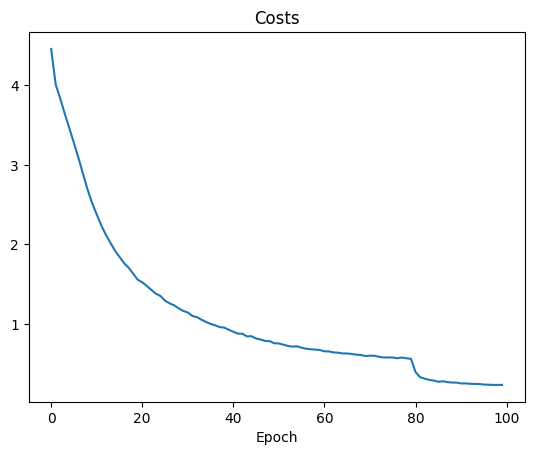

In [8]:
plt.plot(costs)

plt.xlabel("Epoch")

plt.title('Costs')

Text(0.5, 1.0, 'Validation Error Rates')

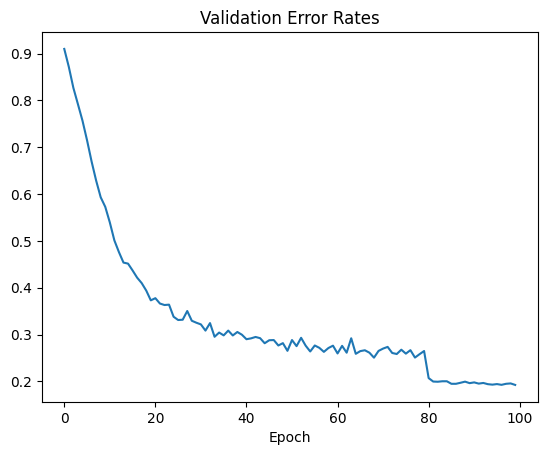

In [9]:
plt.plot(val_error_rates)

plt.xlabel("Epoch")

plt.title('Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

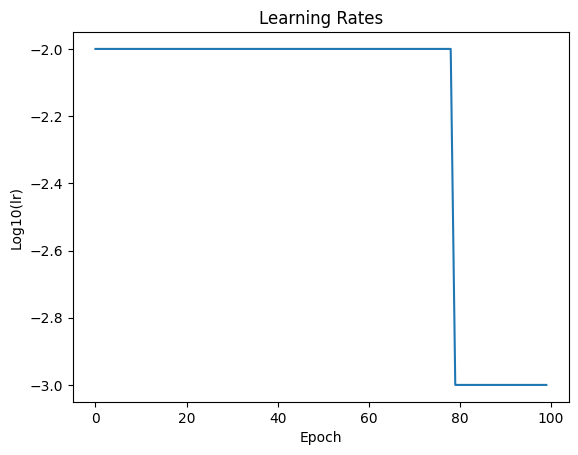

In [10]:
import math



plt.plot([math.log10(lr) for lr in learning_rates])

plt.ylabel("Log10(lr)")

plt.xlabel("Epoch")

plt.title('Learning Rates')